In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

C:\Users\User\anaconda3\envs\env1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])


mnist_trainset = datasets.MNIST(root='../MSAI/computer vision/', train=True, download=True, transform=transform_train)
mnist_testset = datasets.MNIST(root='../MSAI/computer vision/', train=False, download=True, transform=transform_test)


trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=128, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=256, shuffle=False, num_workers=2)

print('Number of training datasets: ', len(mnist_trainset))
print('Number of testing datasets: ',len(mnist_testset))

Number of training datasets:  60000
Number of testing datasets:  10000


torch.Size([128, 1, 28, 28])


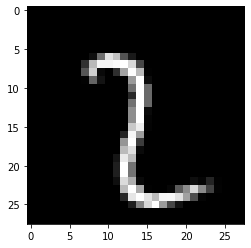

In [3]:
images, labels = next(iter(trainloader))
print(images.shape)
plt.imshow(images[0].reshape(28,28), cmap="gray")

In [4]:
class CNN(nn.Module):

    def __init__(self):

        super(CNN, self).__init__()

       
        self.conv_layer1 = nn.Conv2d(1, 25,  kernel_size=3,  padding=1 )
        self.pool_layer1  = nn.MaxPool2d(2,2)
        
        self.conv_layer2 = nn.Conv2d(25,  100,  kernel_size=3,  padding=1 )
        self.pool_layer2 = nn.MaxPool2d(2,2)
    
        self.linear_layer1 = nn.Linear(4900, 100)
        self.linear_layer2 = nn.Linear(100,10)


    def forward(self, x):

      
        x = self.conv_layer1(x)
        x = F.relu(x)
        x = self.pool_layer1(x)
        
        x = self.conv_layer2(x)
        x = F.relu(x)
        x = self.pool_layer2(x)

      
        x = x.view(-1, 4900)
        x = self.linear_layer1(x)
        x = F.relu(x)
        
        x = self.linear_layer2(x)
    
        return x

In [20]:
import torchvision.models as models

class MnistNet(nn.Module):
    def __init__(self, in_channels = 1):
        super(MnistNet, self).__init__()
        
        self.model = models.resnet18(pretrained = True)
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size = 3, stride = 1, padding = 1)
        linear_last = self.model.fc.in_features
        self.model.fc = nn.Linear(linear_last, 10)
        
    def forward(self, x):
        return self.model(x)

In [21]:
def train(epoch, net, criterion, trainloader, scheduler):
   
    print('\nEpoches: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_index, (inputs, target) in enumerate(trainloader):
        #inputs, target = inputs.to('cuda'), targets.to('cuda') # if got GPU
        inputs, target = inputs, target
        outputs = net(inputs)
        optimizer.zero_grad()
        
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        #top_p, top_class = log_ps.topk(1, dim=1)
        
        train_loss += loss.item()
        #equals = top_class.long() == labels.long().view(*top_class.shape)
        #accuracy += torch.mean(equals.float())
        _, predicted = outputs.max(1)
        total += target.size(0)
        
        correct += predicted.eq(target).sum().item()
        loss_per_iteration = train_loss/(batch_index + 1)
        loss_per_iteration = np.round(loss_per_iteration,3)
        
        accuracy = 100 * (correct / total)
        accuracy =  np.round(accuracy,2) 
        
        if (batch_index +1) % 50 == 0:
            print("iteration : %3d, loss : %0.4f, accuracy : %2.2f" % (batch_index+1, train_loss/(batch_index+1), 100.*correct/total))

    #scheduler.step()
    return train_loss/(batch_index+1), 100.*correct/total

In [22]:
def test(epoch, net, criterion, testloader):
    net.eval()
    
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            #inputs, target = inputs.to('cuda'), targets.to('cuda') # if got GPU
            inputs, target = inputs, targets
            outputs = net(inputs)
            loss = criterion(outputs, target)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/(batch_idx+1), 100.*correct/total


In [23]:
lr = 0.01
momentum =0.9
wd = 0.0005
epochs = 200

my_resnet = MnistNet()
net = CNN() # add .to('cuda') if got GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_resnet.parameters(), lr= lr,momentum= momentum, weight_decay=wd) # change my_resnet to net if you want to change it to CNN
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 200)

In [ ]:
config = {
    'lr': 0.01,
    'momentum': 0.9,
    'weight_decay': 0.0005
}

train_loss_list = []
train_acc_list  = []
test_loss_list  = []
test_acc_list  = []


#net = CNN().to('cuda')

#criterion = nn.CrossEntropyLoss().to('cuda')
#criterion = nn.MSELoss().to('cuda')
#optimizer = optim.AdamW(net.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

#optimizer = optim.SGD(net.parameters(), lr=config['lr'],
                     #momentum=config['momentum'], weight_decay=config['weight_decay'])
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 200)
#print(scheduler)
for epoch in range(0, epochs):
    train_loss, train_acc = train(epoch, net, criterion, trainloader, scheduler)
    test_loss, test_acc = test(epoch, net, criterion, testloader)
    
    print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, test loss " + \
      ": %0.4f, test accuracy : %2.2f") % (epoch, train_loss, train_acc, test_loss, test_acc))
    
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)


Epoches: 0
iteration :  50, loss : 2.3050, accuracy : 10.97
iteration : 100, loss : 2.3045, accuracy : 11.35
iteration : 150, loss : 2.3046, accuracy : 11.37
iteration : 200, loss : 2.3052, accuracy : 11.24
iteration : 250, loss : 2.3055, accuracy : 11.32
iteration : 300, loss : 2.3051, accuracy : 11.34
iteration : 350, loss : 2.3051, accuracy : 11.25
iteration : 400, loss : 2.3053, accuracy : 11.17
iteration : 450, loss : 2.3054, accuracy : 11.24
Epoch :   0, training loss : 2.3055, training accuracy : 11.27, test loss : 2.3050, test accuracy : 11.74

Epoches: 1
iteration :  50, loss : 2.3059, accuracy : 10.59
iteration : 100, loss : 2.3052, accuracy : 10.90
iteration : 150, loss : 2.3050, accuracy : 11.04
iteration : 200, loss : 2.3048, accuracy : 11.25
iteration : 250, loss : 2.3049, accuracy : 11.22
iteration : 300, loss : 2.3054, accuracy : 11.28
iteration : 350, loss : 2.3052, accuracy : 11.28
iteration : 400, loss : 2.3052, accuracy : 11.25
iteration : 450, loss : 2.3053, accur

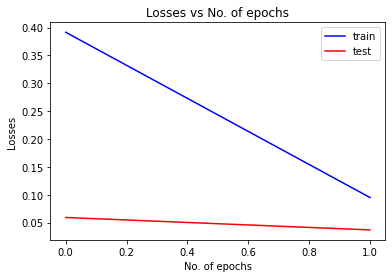

In [16]:
plt.plot(range(len(train_loss_list)), train_loss_list, 'b')
plt.plot(range(len(test_loss_list)), test_loss_list, 'r')
plt.xlabel("No. of epochs")
plt.ylabel("Losses")
plt.title("Losses vs No. of epochs")
plt.legend(['train', 'test'])
plt.show()

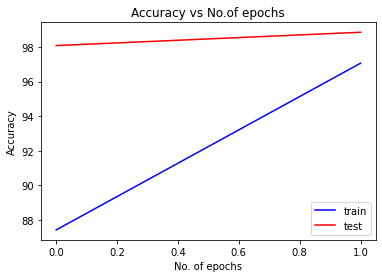

In [17]:
plt.plot(range(len(train_acc_list)), train_acc_list, 'b')
plt.plot(range(len(test_acc_list)), test_acc_list, 'r')
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs No.of epochs")
plt.legend(['train', 'test'])
plt.show()